In [1]:
import os
import numpy as np
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import earthpy as et
import rasterio
from rasterio.enums import Resampling
import matplotlib.pylab as plt



In [76]:

def get_upscale_tranform(veg_path, upscale_factor = 1/10):
    """
    Resample geotiff 
    """
    with rasterio.open(veg_path) as dataset:
        veg_data_mask = dataset.dataset_mask()
        veg_data = dataset.read()    

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * upscale_factor),
                int(dataset.width * upscale_factor)
            ),
            resampling=Resampling.bilinear
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )

        veg_data_mask = dataset.dataset_mask()
        veg_data = dataset.read()
    return transform, veg_data




def upscale_tiff(input_path, upscale_factor):
    transform, input_data = get_upscale_tranform(input_path,upscale_factor)
    
    upscaled_path = '.'.join([input_path.split(".")[0] + '_upscale',
                               
                               input_path.split(".")[1]])
    with rio.open(input_path) as src:

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': transform,
            'width': src.width*upscale_factor,
            'height': src.height*upscale_factor
        })

        with rio.open(upscaled_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform= transform,
                    dst_crs=src.crs,
                    resampling=Resampling.nearest)
    
    
    return upscaled_path

In [222]:
def open_rio(path):
    data2 = rio.open(path)

    data = data2.read().squeeze()
    data = np.array(data, dtype = float)
    data[data < -1.] = np.nan
    return data

In [234]:
def transform_crs(input_path, upscale_factor = 1/6,  dst_crs =  'EPSG:4326'):

    projected_path = '.'.join([input_path.split(".")[0] + '_project',
                               input_path.split(".")[1]])

    upscaled_path = '.'.join([projected_path.split(".")[0] + '_upscale',
                               projected_path.split(".")[1]])    

    with rio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(projected_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest) 
    
    upscale_tiff(projected_path, upscale_factor)                
    

    return upscaled_path

In [235]:
# Get data and set working directory
project_dir = "/Users/octavia/Dropbox/fire/"
veg_dir = os.path.join(project_dir, "fire_data/VegClassifications")
veg_path = os.path.join(veg_dir, "veg69_05m_icb_5.tif")
veg_data = rio.open(veg_path)

upscale_factor = 1/6

veg1969_path = transform_crs(veg_path, upscale_factor)


In [236]:
veg1969 = open_rio(veg1969_path)

In [228]:
rio.open(veg_path).crs

CRS.from_epsg(26911)

In [243]:
soil_dir = os.path.join(project_dir, "fire_data/RF_Soil_Moisture")
soil_path = os.path.join(soil_dir, "vwc_1969_rfor30m.tif")
soil_data = open_rio(soil_path)
rio.open(soil_path).meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -1.7976931348623157e+308,
 'width': 735,
 'height': 632,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"]]'),
 'transform': Affine(30.0, 0.0, -13313326.585713651,
        0.0, -30.0, 4541220.867751249)}

In [230]:

(np.isnan(soil_data) ==0).sum()

202308

In [240]:
(np.isnan(veg1969) ==0).sum()

162279

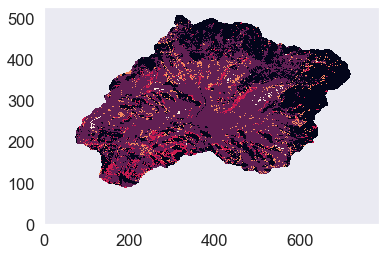

In [232]:
plt.pcolormesh(veg1969)

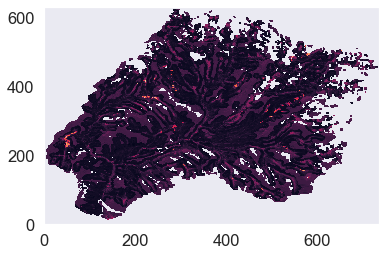

In [233]:
plt.pcolormesh(soil_data)

In [24]:
# with rio.open(lidar_chm_path) as lidar_chm:
lidar_chm_crop, lidar_chm_crop_meta = es.crop_image(veg1969,soil_data.bounds)


NameError: name 'es' is not defined

In [13]:
veg_data = transform_crs(veg_path)

In [72]:

# veg_data = veg_data[:int(nrow*upscale_factor), :int(ncol*upscale_factor)]

(array([ 85513., 136317.,  16089.,  12980.,   1040.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

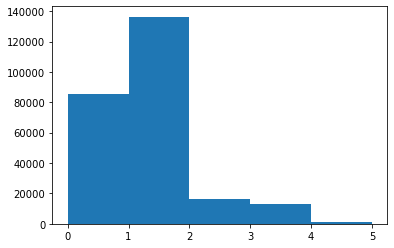

In [74]:
plt.hist((veg_data[~np.isnan(veg_data  )]), bins = [0,1,2,3,4,5])

In [43]:
# View image structure
with rio.open(veg69_05m_icb_5) as veg_data:
    print(veg_data.tags(ns='IMAGE_STRUCTURE'))
    veg_data_mask = veg_data.dataset_mask()
    veg_data = veg_data.read()

RasterioIOError: Dataset is closed: /Users/octavia/Dropbox/fire/fire_data/VegClassifications/veg69_05m_icb_5.tif

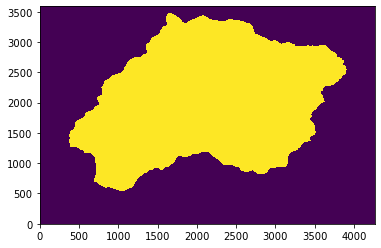

In [30]:
plt.pcolormesh(veg_data_mask)


In [26]:
veg_data

array([[[-2147483648, -2147483648, -2147483648, ..., -2147483648,
         -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648, ..., -2147483648,
         -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648, ..., -2147483648,
         -2147483648, -2147483648],
        ...,
        [-2147483648, -2147483648, -2147483648, ..., -2147483648,
         -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648, ..., -2147483648,
         -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648, ..., -2147483648,
         -2147483648, -2147483648]]], dtype=int32)

In [18]:
print(lidar_dem.crs)
print(lidar_dem.bounds)

EPSG:26911
BoundingBox(left=269366.3211650733, bottom=4163244.3001163187, right=290671.3211650733, top=4181184.3001163187)


In [40]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import mapping
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Prettier plotting with seaborn
sns.set(font_scale=1.5)

# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [41]:

aoi = os.path.join("data", "colorado-flood", "spatial",
                   "boulder-leehill-rd", "clip-extent.shp")

# Open crop extent (your study area extent boundary)
crop_extent = gpd.read_file(aoi)

In [42]:
crop_extent

,id,geometry
0,1,"POLYGON ((472510.465 4436000.000, 476009.764 4..."


In [48]:
lidar_chm_path = os.path.join("data", "colorado-flood", "spatial",
                              "boulder-leehill-rd", "outputs", "lidar_chm.tif")

with rio.open(lidar_chm_path) as lidar_chm:
    lidar_chm_crop, lidar_chm_crop_meta = es.crop_image(lidar_chm,crop_extent)

lidar_chm_crop_affine = lidar_chm_crop_meta["transform"]

# Create spatial plotting extent for the cropped layer
lidar_chm_extent = plotting_extent(lidar_chm_crop[0], lidar_chm_crop_affine)

In [ ]:
lidar_chm_path

In [47]:
lidar_chm_crop_meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': -1.7e+308,
 'width': 3490,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472510.0,
        0.0, -1.0, 4436000.0)}